![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [8]:
import pandas as pd
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt

filename_features = "UCI HAR Dataset/features.txt"
filename_labels = "UCI HAR Dataset/activity_labels.txt"

filename_subtrain = "UCI HAR Dataset/train/subject_train.txt"
filename_xtrain = "UCI HAR Dataset/train/X_train.txt"
filename_ytrain = "UCI HAR Dataset/train/y_train.txt"

filename_subtest = "UCI HAR Dataset/test/subject_test.txt"
filename_xtest = "UCI HAR Dataset/test/X_test.txt"
filename_ytest = "UCI HAR Dataset/test/y_test.txt"

features_df = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
features = features_df['nome_var']

labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

subject_train_df = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
subject_train = subject_train_df['subject_id']

X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test_df = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
subject_test = subject_test_df['subject_id']

X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\shinoki\AppData\Local\Temp\ipykernel_15856\3050394228.py:26: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
C:\Users\shinoki\AppData\Local\Temp\ipykernel_15856\3050394228.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=features.tolist())
C:\Users\shinoki\AppData\Local\Temp\ipykernel_15856\3050394228.py:37: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=features.tolist())


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [9]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 375 ms
Wall time: 417 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


Sem padronização:
   Componente  Variância (%)  Acumulada (%)
0           1      62.554440      62.554440
1           2       4.913023      67.467463
2           3       4.121467      71.588930
3           4       1.874956      73.463886
4           5       1.694860      75.158746
5           6       1.272069      76.430816
6           7       1.176685      77.607501
7           8       1.068973      78.676474
8           9       0.969380      79.645854
9          10       0.858018      80.503872

Com padronização:
   Componente  Variância (%)  Acumulada (%)
0           1      50.781172      50.781172
1           2       6.580680      57.361853
2           3       2.806437      60.168289
3           4       2.503953      62.672242
4           5       1.888285      64.560527
5           6       1.724006      66.284534
6           7       1.371011      67.655545
7           8       1.199078      68.854623
8           9       0.995860      69.850482
9          10       0.965087      70.81

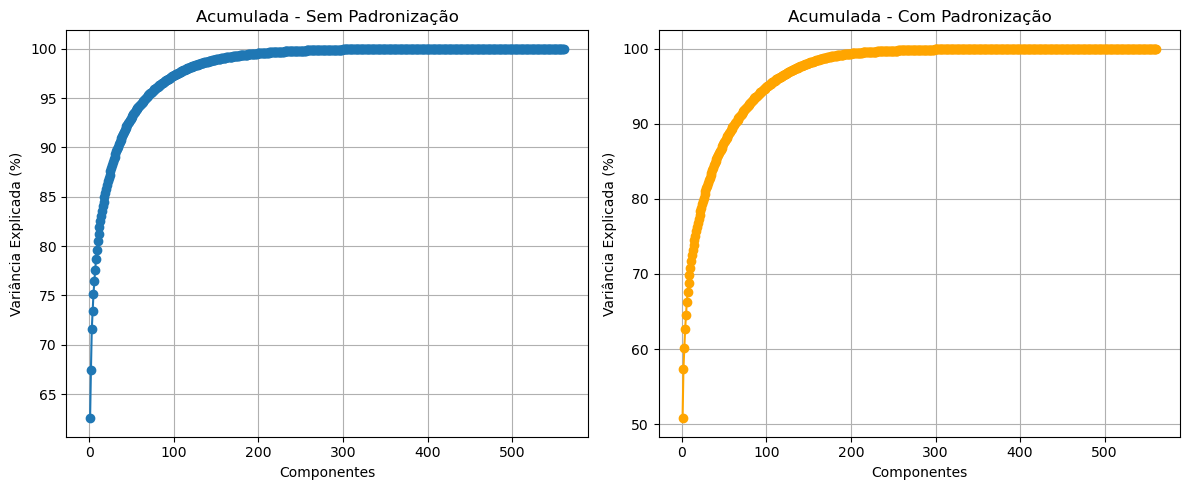

In [10]:
pca_raw = PCA()
pca_raw.fit(X_train)

var_exp_raw = pca_raw.explained_variance_
var_exp_ratio_raw = pca_raw.explained_variance_ratio_
var_exp_ratio_acum_raw = np.cumsum(var_exp_ratio_raw)

pca_pad = PCA()
pca_pad.fit(X_train_pad)

var_exp_pad = pca_pad.explained_variance_
var_exp_ratio_pad = pca_pad.explained_variance_ratio_
var_exp_ratio_acum_pad = np.cumsum(var_exp_ratio_pad)

df_raw = pd.DataFrame({
    'Componente': np.arange(1, len(var_exp_raw)+1),
    'Variância (%)': var_exp_ratio_raw * 100,
    'Acumulada (%)': var_exp_ratio_acum_raw * 100
})

df_pad = pd.DataFrame({
    'Componente': np.arange(1, len(var_exp_pad)+1),
    'Variância (%)': var_exp_ratio_pad * 100,
    'Acumulada (%)': var_exp_ratio_acum_pad * 100
})

print("Sem padronização:")
print(df_raw.head(10))

print("\nCom padronização:")
print(df_pad.head(10))

n_comp_90_raw = np.argmax(var_exp_ratio_acum_raw >= 0.90) + 1
n_comp_90_pad = np.argmax(var_exp_ratio_acum_pad >= 0.90) + 1

print(f"\nComponentes para 90% da variância (sem padronização): {n_comp_90_raw}")
print(f"Componentes para 90% da variância (com padronização): {n_comp_90_pad}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df_raw['Componente'], df_raw['Acumulada (%)'], marker='o')
plt.title('Acumulada - Sem Padronização')
plt.xlabel('Componentes')
plt.ylabel('Variância Explicada (%)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_pad['Componente'], df_pad['Acumulada (%)'], marker='o', color='orange')
plt.title('Acumulada - Com Padronização')
plt.xlabel('Componentes')
plt.ylabel('Variância Explicada (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [12]:
X_test_pad = pd.DataFrame(X_test).apply(padroniza, axis=0)


In [13]:
%%time

pca_raw = PCA(n_components=10)
X_train_pca_raw = pca_raw.fit_transform(X_train)
X_test_pca_raw = pca_raw.transform(X_test)

pca_pad = PCA(n_components=10)
X_train_pca_pad = pca_pad.fit_transform(X_train_pad)
X_test_pca_pad = pca_pad.transform(X_test_pad)  

tree_raw = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_raw.fit(X_train_pca_raw, y_train.values.ravel())

acc_train_raw = accuracy_score(y_train, tree_raw.predict(X_train_pca_raw))
acc_test_raw = accuracy_score(y_test, tree_raw.predict(X_test_pca_raw))

tree_pad = DecisionTreeClassifier(ccp_alpha=0.001, random_state=42)
tree_pad.fit(X_train_pca_pad, y_train.values.ravel())

acc_train_pad = accuracy_score(y_train, tree_pad.predict(X_train_pca_pad))
acc_test_pad = accuracy_score(y_test, tree_pad.predict(X_test_pca_pad))

print("Árvore com PCA (sem padronização):")
print(f"Acurácia treino: {acc_train_raw:.4f}")
print(f"Acurácia teste : {acc_test_raw:.4f}\n")

print("Árvore com PCA (com padronização):")
print(f"Acurácia treino: {acc_train_pad:.4f}")
print(f"Acurácia teste : {acc_test_pad:.4f}")


Árvore com PCA (sem padronização):
Acurácia treino: 0.8932
Acurácia teste : 0.8229

Árvore com PCA (com padronização):
Acurácia treino: 0.8592
Acurácia teste : 0.7805
CPU times: total: 1.27 s
Wall time: 1.16 s
